In [141]:
import pandas
import numpy
import pygsheets
import scipy.stats
import datetime
import matplotlib
import matplotlib.pyplot as mp

import re

## colors for plots

In [142]:
sel_cmap = matplotlib.cm.get_cmap('Oranges')
tracker_construction = sel_cmap(1.0)
tracker_proposed = sel_cmap(0.75)

## import terminals data from sheet

In [143]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1uyMeL9f2zF3YlpTUlvptrP9YW-reCrO_tLibyOi_emk') # copy for this report

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A2')

In [144]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Fuel']!='Oil']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

In [145]:
region_df_orig = spreadsheet.worksheet('title', 'Region dictionary').get_as_df(start='A2')

region_df_africa = region_df_orig.loc[(region_df_orig['AfricaGasTracker']=='Yes')]
region_df_touse = region_df_africa.copy()

In [146]:
owners_df_orig = spreadsheet.worksheet('title', 'Terminal operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ComboID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df()
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ComboID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

In [147]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(terms_df_orig['Country'])))
region_list = sorted(list(set(terms_df_orig['Region'])))

## table for exports

In [108]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

mtpa_by_region_export_df = mtpa_by_region_df.copy()
mtpa_by_country_export_df = mtpa_by_country_df.copy()

mtpa_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1996867698.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_region_df = mtpa_by_region_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1996867698.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_country_df = mtpa_by_country_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,421.15,39.36,460.51,12.29,444.11,73.90,15.3,1.50,0.0
Eurasia,115.40,19.60,135.00,14.42,16.36,30.60,0.0,0.00,0.0
Sub-Saharan Africa,77.42,10.52,87.94,34.10,27.39,37.72,0.0,0.00,0.0
Middle East and North Africa,63.60,1.07,64.67,22.00,87.75,136.94,0.0,10.40,7.8
SE Asia,19.50,5.80,25.30,1.50,12.55,66.65,0.0,0.00,30.1
Australia and New Zealand,20.10,0.00,20.10,7.20,45.80,87.60,0.0,0.00,0.0
Latin America and the Caribbean,5.37,0.00,5.37,0.00,16.60,16.45,0.0,3.75,0.0
East Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0
Europe,0.00,0.00,0.00,0.00,5.04,4.68,0.0,0.00,0.0
South Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0


## table for imports

In [109]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
# drop all all-zero columns
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-import.xlsx')

mtpa_by_region_import_df = mtpa_by_region_df.copy()
mtpa_by_country_import_df = mtpa_by_country_df.copy()

mtpa_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1390453538.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_region_df = mtpa_by_region_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1390453538.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_country_df = mtpa_by_country_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,149.76,91.25,241.01,25.80,54.49,444.10,0.0,1.5,0.0
Europe,136.72,28.61,165.33,14.20,91.24,181.03,0.0,0.0,3.0
South Asia,69.71,33.00,102.71,8.38,80.95,65.20,0.0,0.0,0.0
SE Asia,76.84,21.66,98.50,8.40,28.34,45.05,0.0,0.0,0.0
Latin America and the Caribbean,43.48,12.28,55.76,6.46,16.07,53.36,0.0,0.0,0.0
Sub-Saharan Africa,6.88,1.70,8.58,0.50,7.70,0.11,0.0,0.0,0.0
Australia and New Zealand,3.30,1.90,5.20,0.00,1.75,0.00,0.0,0.0,0.0
Middle East and North Africa,5.15,0.00,5.15,11.10,18.64,48.90,11.8,0.0,0.0
North America,0.05,0.00,0.05,0.00,268.42,81.10,25.0,45.0,17.3
Eurasia,0.00,0.00,0.00,0.00,0.00,12.20,0.0,0.0,0.0


# table 1

In [110]:
status = ['Operating']
mtpa_by_country_import_df_subset = mtpa_by_country_import_df.loc[(mtpa_by_country_import_df.index.isin(region_df_touse.Country))]
mtpa_by_country_import_df_subset = mtpa_by_country_import_df_subset.sort_values(status, ascending=False)[status]
# sum everything after top 5
upto = 2
rest_of_africa = pandas.DataFrame(mtpa_by_country_import_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([mtpa_by_country_import_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Operating
Country,
Egypt,5.70
Senegal,0.11
Rest of Africa,0.00
Total,5.81


## fig for table 2

# table 2

In [111]:
status = ['Operating']
mtpa_by_country_export_df_subset = mtpa_by_country_export_df.loc[(mtpa_by_country_export_df.index.isin(region_df_touse.Country))]
mtpa_by_country_export_df_subset = mtpa_by_country_export_df_subset.sort_values(status, ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(mtpa_by_country_export_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([mtpa_by_country_export_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Operating
Country,
Algeria,29.34
Nigeria,23.02
Egypt,12.20
Angola,5.20
Equatorial Guinea,3.70
Rest of Africa,5.80
Total,79.26


## fig for table 2 (now Fig 1)

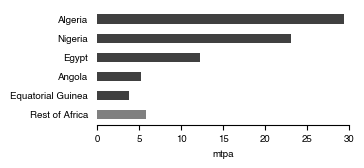

In [112]:
font_size = 7
set_width = 0.5
use_this_df = final_table.sort_values('Operating').drop('Total')
rest_df = use_this_df.loc[['Rest of Africa']]
use_this_df = pandas.concat([rest_df, use_this_df.drop('Rest of Africa')])
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,1.5))
ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Operating'],
       color=['0.5']+['0.25']*5, label=['Operating']*use_this_df.index.size, height=set_width)

# ax_h,ax_l = ax.get_legend_handles_labels()
# ax.legend([ax_h[-1]], [ax_l[-1]], fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('mtpa', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
ax.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
#ax.set_ylim(ybot,ytop)
ax.set_xlim(0, 30)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# ax.set_title('Regional Export Capacity', fontsize=font_size)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1.svg',
          bbox_inches='tight', 
          transparent=True)

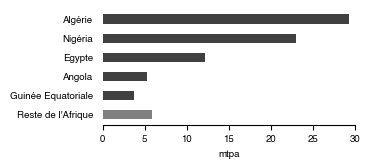

In [113]:
font_size = 7
set_width = 0.5
use_this_df = final_table.sort_values('Operating').drop('Total')
rest_df = use_this_df.loc[['Rest of Africa']]
use_this_df = pandas.concat([rest_df, use_this_df.drop('Rest of Africa')])
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,1.5))
ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Operating'],
       color=['0.5']+['0.25']*5, label=['Operating']*use_this_df.index.size, height=set_width)

# ax_h,ax_l = ax.get_legend_handles_labels()
# ax.legend([ax_h[-1]], [ax_l[-1]], fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('mtpa', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
fr_labels = ["Algérie",
"Nigéria",
"Egypte",
"Angola",
"Guinée Equatoriale",
"Reste de l'Afrique"][::-1]
ax.yaxis.set_ticklabels(fr_labels, size=font_size, va='center')
#ax.set_ylim(ybot,ytop)
ax.set_xlim(0, 30)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# ax.set_title('Regional Export Capacity', fontsize=font_size)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1-Fr.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1-Fr.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1-Fr.svg',
          bbox_inches='tight', 
          transparent=True)

# table 4

In [114]:
status = ['Proposed','Construction','Proposed+Construction']
mtpa_by_country_export_df_subset = mtpa_by_country_export_df.loc[(mtpa_by_country_export_df.index.isin(region_df_touse.Country))]
mtpa_by_country_export_df_subset = mtpa_by_country_export_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(mtpa_by_country_export_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([mtpa_by_country_export_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Proposed,Construction,Proposed+Construction
Country,,,
Nigeria,16.02,8.00,24.02
Mauritania,17.50,2.52,20.02
Mozambique,15.20,0.00,15.20
Tanzania,10.00,0.00,10.00
Senegal,10.00,0.00,10.00
Rest of Africa,8.70,0.07,8.77
Total,77.42,10.59,88.01


## figure for table 4 (now Fig 3)

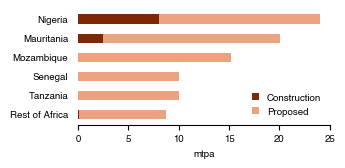

In [115]:
font_size = 7
set_width = 0.5
use_this_df = final_table.sort_values('Proposed+Construction').drop('Total')
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,1.5))
ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Construction'],
       color=tracker_construction, label='Construction', height=set_width)
ax.barh(range(use_this_df.index.size), use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df['Construction'], height=set_width, alpha=0.5)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('mtpa', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
ax.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
#ax.set_ylim(ybot,ytop)
ax.set_xlim(0, 25)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# ax.set_title('Regional Export Capacity', fontsize=font_size)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3.svg',
          bbox_inches='tight', 
          transparent=True)

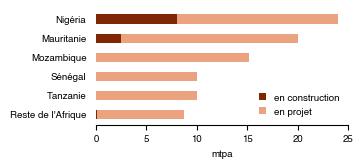

In [116]:
font_size = 7
set_width = 0.5
use_this_df = final_table.sort_values('Proposed+Construction').drop('Total')
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,1.5))
ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Construction'],
       color=tracker_construction, label='en construction', height=set_width)
ax.barh(range(use_this_df.index.size), use_this_df['Proposed'],
       color=tracker_proposed, label='en projet',
      left=use_this_df['Construction'], height=set_width, alpha=0.5)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('mtpa', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
fr_labels = ["Nigéria",
"Mauritanie",
"Mozambique",
"Sénégal",
"Tanzanie",
"Reste de l'Afrique"][::-1]
ax.yaxis.set_ticklabels(fr_labels, size=font_size, va='center')
#ax.set_ylim(ybot,ytop)
ax.set_xlim(0, 25)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# ax.set_title('Regional Export Capacity', fontsize=font_size)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3-Fr.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3-Fr.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3-Fr.svg',
          bbox_inches='tight', 
          transparent=True)

# import terminals table

In [117]:
status = ['Proposed','Construction','Proposed+Construction']
mtpa_by_country_import_df_subset = mtpa_by_country_import_df.loc[(mtpa_by_country_import_df.index.isin(region_df_touse.Country))]
mtpa_by_country_import_df_subset = mtpa_by_country_import_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(mtpa_by_country_import_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([mtpa_by_country_import_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Proposed,Construction,Proposed+Construction
Country,,,
South Africa,6.00,0.0,6.00
Morocco,5.15,0.0,5.15
Ghana,0.00,1.7,1.70
Mozambique,0.50,0.0,0.50
Côte d'Ivoire,0.38,0.0,0.38
Rest of Africa,0.00,0.0,0.00
Total,12.03,1.7,13.73


# cost calculations

## create offshore and floating dfs

In [118]:
# insane outliers
# Ravenna - T068300
# Gorgon LNG (megaproject) - T068300
# Tanzania LNG Terminal trains 1, 2 - T026301, T026302
# Coral South FLNG Terminal - includes deep gas well construction - T025801
outlier_comboids = ['T068300','T068300','T026301','T026302','T025801']

In [119]:
terms_df_floating = terms_df_orig.loc[terms_df_orig.Floating=='yes']
terms_df_onshore = terms_df_orig.loc[terms_df_orig.Floating=='']

#terms_df_floating = terms_df_floating.loc[~terms_df_floating.ComboID.isin(outlier_comboids)]
#terms_df_onshore = terms_df_onshore.loc[~terms_df_onshore.ComboID.isin(outlier_comboids)]
terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

In [120]:
terms_df_floating_noexpansions = terms_df_floating.loc[~terms_df_floating['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')
terms_df_onshore_noexpansions = terms_df_onshore.loc[~terms_df_onshore['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')

## import

In [121]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/935618189.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&


TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Tema FSRU,Ghana,Construction,https://www.gem.wiki/Tema_FSRU,205882352.900000
Coega FSRU,South Africa,Proposed,https://www.gem.wiki/Coega_FSRU,500000000.000000
Kutubdia (Reliance) FSRU,Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_(Reliance)_FSRU,84444444.270000
Moheshkhali FLNG Terminal (Petrobangla),Bangladesh,Operating,https://www.gem.wiki/Moheshkhali_FLNG_Terminal_(Petrobangla),47236842.110000
Jawa Satu FSRU,Indonesia,Operating,https://www.gem.wiki/Jawa_Satu_FSRU,145833333.300000
Newcastle FSRU,Australia,Proposed,https://www.gem.wiki/Newcastle_FSRU,406410000.000000
Eagle FLNG Terminal,Albania,Cancelled,https://www.gem.wiki/Eagle_FLNG_Terminal,140740740.700000
Krk FSRU,Croatia,Operating,https://www.gem.wiki/Krk_FSRU,124887381.400000
Cyprus LNG Terminal,Cyprus,Construction,https://www.gem.wiki/Cyprus_LNG_Terminal,592800000.000000
Wilhelmshaven FSRU,Germany,Construction,https://www.gem.wiki/Wilhelmshaven_FSRU,93023991.320000


In [122]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1041829456.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&


TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Jorf Lasfar LNG Terminal,Morocco,Proposed,https://www.gem.wiki/Jorf_Lasfar_LNG_Terminal,874285632.700000
Kutubdia LNG Terminal (Petronet),Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_LNG_Terrminal_(Petronet),84444444.400000
Lahad Datu Sabah LNG Terminal,Malaysia,Cancelled,https://www.gem.wiki/Lahad_Datu_Sabah_LNG_Terminal,317105263.200000
Pengerang Johor LNG Terminal,Malaysia,Operating,https://www.gem.wiki/Pengerang_Johur_LNG_Terminal,169714285.700000
Gwadar LNG Terminal,Pakistan,Proposed,https://www.gem.wiki/Gwadar_LNG_Terminal,630136986.300000
Singapore LNG Terminal,Singapore,Operating,https://www.gem.wiki/Singapore_LNG_Terminal,154545454.500000
Boryeong LNG Terminal,South Korea,Operating,https://www.gem.wiki/Boryeong_LNG_Terminal,144210000.000000
Samcheok LNG Terminal,South Korea,Operating,https://www.gem.wiki/Samcheok_LNG_Terminal,132222222.200000
Kerewalapitiya LNG Terminal,Sri Lanka,Shelved,https://www.gem.wiki/Kerewalapitiya_LNG_Terminal,92592592.590000
Taichung LNG Terminal,Taiwan,Operating,https://www.gem.wiki/Taichung_LNG_Terminal,357000000.000000


## export list

In [123]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/391694351.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&


TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,583333333.300000
Cameroon FLNG Terminal,Cameroon,Operating,https://www.gem.wiki/Cameroon_FLNG_Terminal,500000000.000000
Fortuna FLNG Terminal,Equatorial Guinea,Cancelled,https://www.gem.wiki/Fortuna_FLNG_Terminal,793650793.700000
Cedar FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Cedar_FLNG_Terminal,800000000.000000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.100000
Greater Tortue Ahmeyim FLNG Terminal,Mauritania,Construction,https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,463680000.000000
Etinde FLNG Terminal,Cameroon,Proposed,https://www.gem.wiki/Etinde_FLNG_Terminal,384615384.600000
Ksi Lisims FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Ksi_Lisims_FLNG_Terminal,833333333.300000
New Fortress Grand Isle FLNG Terminal,United States,Proposed,https://www.gem.wiki/New_Fortress_Grand_Isle_FLNG_Terminal,500000000.000000


In [124]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/978177273.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&


TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Eagle LNG Terminal,United States,Proposed,https://www.gem.wiki/Eagle_LNG_Terminal,547474747.500000
G2 LNG Terminal,United States,Proposed,https://www.gem.wiki/G2_LNG_Terminal,846153846.200000
Golden Pass LNG Terminal,United States,Construction,https://www.gem.wiki/Golden_Pass_LNG,552486187.800000
Gulf LNG Terminal,United States,Proposed,https://www.gem.wiki/Gulf_LNG,736648250.500000
Port Arthur LNG Terminal,United States,Proposed,https://www.gem.wiki/Point_Arthur_LNG_Terminal,62962962.960000
Plaquemines LNG Terminal,United States,Proposed,https://www.gem.wiki/Venture_Global_Plaquemines_LNG_Terminal,990247561.900000
Egyptian LNG Terminal,Egypt,Operating,https://www.gem.wiki/ELNG_IDCO_Terminal,311111111.100000
Punta Europa LNG Terminal,Equatorial Guinea,Operating,https://www.gem.wiki/Punta_Europa_LNG_Terminal,405405405.400000
Mozambique LNG Terminal,Mozambique,Shelved,https://www.gem.wiki/Mozambique_LNG_Terminal,775193798.400000


### make dataframe to use for terminal calculations

* regional averages for onshore terminals
  * fewer than 3 data points, then apply a global value rather than a regional one!
* global averages for offshore terminals

In [125]:
onshore_export_regional_costs = pandas.DataFrame(index=region_list)

onshore_export_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_export_regional_costs.loc[(onshore_export_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
print('export onshore')
onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = onshore_export_regional_costs['RegionalCostUSDPerMtpa']
onshore_export_regional_costs

export onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,4.0,5.949954e+08
East Asia,NaN,5.882834e+08
Eurasia,1.0,5.882834e+08
Europe,NaN,5.882834e+08
Latin America and the Caribbean,3.0,5.239181e+08
Middle East and North Africa,6.0,5.447671e+08
North America,11.0,5.743181e+08
SE Asia,1.0,5.882834e+08
South Asia,NaN,5.882834e+08
Sub-Saharan Africa,5.0,6.235952e+08


In [126]:
onshore_import_regional_costs = pandas.DataFrame(index=region_list)

onshore_import_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_import_regional_costs.loc[(onshore_import_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
print('import onshore')
onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = onshore_import_regional_costs['RegionalCostUSDPerMtpa']
onshore_import_regional_costs

import onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,1.0,2.696893e+08
East Asia,15.0,3.516386e+08
Eurasia,NaN,2.696893e+08
Europe,15.0,2.325106e+08
Latin America and the Caribbean,4.0,3.104855e+08
Middle East and North Africa,2.0,2.696893e+08
North America,2.0,2.696893e+08
SE Asia,9.0,2.049370e+08
South Asia,7.0,2.102106e+08
Sub-Saharan Africa,NaN,2.696893e+08


In [127]:
floating_export_regional_costs = pandas.DataFrame(index=region_list)

floating_export_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_export_regional_costs.loc[:,
                                #(floating_export_regional_costs.NumberOfDataPoints<3) | 
                                #  (floating_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
print('export floating')
floating_export_regional_costs['RegionalCostUSDPerMtpa'] = floating_export_regional_costs['RegionalCostUSDPerMtpa']
floating_export_regional_costs

export floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,NaN,5.674729e+08
East Asia,NaN,5.674729e+08
Eurasia,1.0,5.674729e+08
Europe,NaN,5.674729e+08
Latin America and the Caribbean,NaN,5.674729e+08
Middle East and North Africa,NaN,5.674729e+08
North America,4.0,5.674729e+08
SE Asia,NaN,5.674729e+08
South Asia,NaN,5.674729e+08
Sub-Saharan Africa,4.0,5.674729e+08


In [128]:
floating_import_regional_costs = pandas.DataFrame(index=region_list)

floating_import_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_import_regional_costs.loc[:,
                                   #(floating_import_regional_costs.NumberOfDataPoints<3) | 
                                  #(floating_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
print('import floating')
floating_import_regional_costs['RegionalCostUSDPerMtpa'] = floating_import_regional_costs['RegionalCostUSDPerMtpa']
floating_import_regional_costs

import floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,3.0,1.346993e+08
East Asia,NaN,1.346993e+08
Eurasia,NaN,1.346993e+08
Europe,15.0,1.346993e+08
Latin America and the Caribbean,3.0,1.346993e+08
Middle East and North Africa,NaN,1.346993e+08
North America,NaN,1.346993e+08
SE Asia,4.0,1.346993e+08
South Asia,8.0,1.346993e+08
Sub-Saharan Africa,2.0,1.346993e+08


### global calculations

In [129]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_error = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

In [130]:
cost_onshore_export

array([5.88283392e+08])

In [131]:
cost_floating_export

array([5.67472856e+08])

In [132]:
cost_onshore_import

array([2.69689349e+08])

In [133]:
cost_floating_import

array([1.34699251e+08])

## now calculate the import terminal costs

In [134]:
terms_df_import = terms_df_orig.loc[terms_df_orig['Import/Export']=='Import'].reset_index(drop=True)

terms_df_import['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    floating_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    onshore_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostEstUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostEstUSD']

## and calculate export terminal costs

In [135]:
terms_df_export = terms_df_orig.loc[terms_df_orig['Import/Export']=='Export'].reset_index(drop=True)

terms_df_export['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    floating_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    onshore_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostEstUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostEstUSD']

## import terminal costs table

In [136]:
#mtpa by country
cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Country')['CostUSDTotal'].sum(min_count=1)

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Region')['CostUSDTotal'].sum(min_count=1)

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_import_df.index:
    cost_by_region_import_df.drop(index='Total', inplace=True)   
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

else:
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

# total
if 'Total' in cost_by_country_import_df.index:
    cost_by_country_import_df.drop(index='Total', inplace=True)   
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

else:
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
cost_by_country_import_df.to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df/1e9

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1881541370.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_region_import_df = cost_by_region_import_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1881541370.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_country_import_df = cost_by_country_import_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,49.999150,31.296423,81.295573,7.127834,18.509968,154.528032,0.000000,0.527458,0.000000
Europe,25.896968,3.311242,29.208209,3.129799,18.624343,40.023233,0.000000,0.000000,0.404098
SE Asia,18.613397,2.830531,21.443929,2.903390,7.505797,7.209944,0.000000,0.000000,0.000000
South Asia,10.806167,5.689783,16.495950,1.763693,13.623280,12.273269,0.000000,0.000000,0.000000
Latin America and the Caribbean,4.550742,1.654107,6.204849,0.870157,4.374250,8.683066,0.000000,0.000000,0.000000
Middle East and North Africa,4.500000,0.000000,4.500000,1.495162,5.027009,8.469662,1.589451,0.000000,0.000000
Sub-Saharan Africa,3.170584,0.350000,3.520584,0.067350,1.037184,0.014817,0.000000,0.000000,0.000000
Australia and New Zealand,0.716910,0.172500,0.889410,0.000000,0.172500,0.000000,0.000000,0.000000,0.000000
North America,0.013484,0.000000,0.013484,0.000000,64.668235,20.456647,6.337263,12.136021,4.665626
Eurasia,0.000000,0.000000,0.000000,0.000000,0.000000,2.925737,0.000000,0.000000,0.000000


## export terminal costs table

In [137]:
#mtpa by country
cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Country')['CostUSDTotal'].sum(min_count=1)

for status in status_list:
    #print(status)
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Region')['CostUSDTotal'].sum(min_count=1)

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_export_df.index:
    cost_by_region_export_df.drop(index='Total', inplace=True)   
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

else:
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

# total
if 'Total' in cost_by_country_export_df.index:
    cost_by_country_export_df.drop(index='Total', inplace=True)   
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

else:
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
cost_by_country_export_df.to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df/1e9

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1105072155.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_region_export_df = cost_by_region_export_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_25103/1105072155.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_country_export_df = cost_by_country_export_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,293.895765,30.175292,324.071057,11.161820,254.402163,42.442106,8.787066,0.861477,0.000000
Sub-Saharan Africa,87.060503,8.001305,95.061808,24.680967,17.401679,33.993814,0.000000,0.000000,0.000000
Eurasia,72.122808,19.100000,91.222808,14.917706,11.666832,18.001472,0.000000,0.000000,0.000000
Middle East and North Africa,54.317129,0.582901,54.900029,11.984877,58.593035,68.074428,0.000000,5.665578,4.249184
SE Asia,36.549537,2.376567,38.926104,0.882425,12.028338,55.522627,0.000000,0.000000,17.707330
Australia and New Zealand,28.301483,0.000000,28.301483,17.250000,30.920755,176.846423,0.000000,0.000000,0.000000
Latin America and the Caribbean,10.000000,0.000000,10.000000,0.000000,8.740743,6.481188,0.000000,0.974175,0.000000
East Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Europe,0.000000,0.000000,0.000000,0.000000,6.000000,6.182376,0.000000,0.000000,0.000000
South Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# ownership info

In [238]:
terms_df_all = pandas.concat([terms_df_import,terms_df_export], ignore_index=True)
terms_df_all.set_index('ComboID', inplace=True)
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&(terms_df_orig.Status.isin(['Proposed','Construction']))&
                                 (terms_df_orig.Country.isin(region_df_touse.Country.tolist()))].iterrows():
    parent_string = row.Parent#.values[0]
    #print(parent_string)
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have a Owner [%] syntax
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ComboID':row.ComboID,
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'TerminalCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'Region':row.Region,
                                                                         'CapacityInMtpa':row.CapacityInMtpa,
                                                                         'ProjectWiki':row.Wiki,
                                                                         'ProjectName':row.TerminalName+' '+str(row.UnitName),
                                                                         'CostUSDTotal':terms_df_all.loc[row.ComboID]['CostUSDTotal']}])])

owner_parent_calculations_df['MtpaOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.CapacityInMtpa
owner_parent_calculations_df['CostsByOwner'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.CostUSDTotal


In [239]:
parent_country_mtpa_df = \
owner_parent_calculations_df.loc[(owner_parent_calculations_df.TerminalCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['Proposed','Construction']))]

In [247]:
parent_country_mtpa_df_table = pandas.DataFrame(index=parent_country_mtpa_df.Parent.unique().tolist(),
                                             columns=['Terminal Names', 'Terminal Wikis', 'Terminal Country Locations','Owner Headquarters Country',
                                                      'Proposed','Construction','In Development (Proposed + Construction)','ComboIDs', 'Total Capex'])

In [248]:
parent_country_mtpa_df_table['Proposed'] = parent_country_mtpa_df.loc[parent_country_mtpa_df.Status=='Proposed'].groupby('Parent').sum('MtpaOwnershipByCountry')[['MtpaOwnershipByCountry']]
parent_country_mtpa_df_table['Construction'] = parent_country_mtpa_df.loc[parent_country_mtpa_df.Status=='Construction'].groupby('Parent').sum('MtpaOwnershipByCountry')[['MtpaOwnershipByCountry']]



In [250]:
pandas.options.display.max_colwidth = 500
#pandas.DataFrame(owner_parent_calculations_df.groupby('Parent')['PipelineCountry'].transform(lambda x: ', '.join(x.unique()))).set_index(owner_parent_calculations_df.Parent)
#owner_parent_calculations_df.groupby(['Parent']).agg({'PipelineCountry': [pandas.Series.unique,', '.join]})
country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).TerminalCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ComboID.agg(lambda x: ', '.join(x.unique())))
names_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectName.agg(lambda x: ', '.join(x.unique())))
wikis_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectWiki.agg(lambda x: ', '.join(x.unique())))

parent_country_mtpa_df_table['Terminal Country Locations'] = country_agg_df.TerminalCountry
parent_country_mtpa_df_table['ComboIDs'] = projectid_agg_df.ComboID
parent_country_mtpa_df_table['Total Capex'] = owner_parent_calculations_df.groupby('Parent')['CostsByOwner'].sum()/1e9
parent_country_mtpa_df_table['Terminal Names'] = names_agg_df.ProjectName
parent_country_mtpa_df_table['Terminal Wikis'] = wikis_agg_df.ProjectWiki
parent_country_mtpa_df_table['Owner Headquarters Country'] = parent_country_mtpa_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_mtpa_df_table['In Development (Proposed + Construction)'] = parent_country_mtpa_df_table[['Proposed','Construction']].sum(axis=1, min_count=0)
parent_country_mtpa_df_table.loc[~parent_country_mtpa_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:20]
                 

,Terminal Names,Terminal Wikis,Terminal Country Locations,Owner Headquarters Country,Proposed,Construction,In Development (Proposed + Construction),ComboIDs,Total Capex
Nigerian National Petroleum Corporation,"Nigeria LNG Terminal T7, Nigeria LNG Terminal T8, Nigeria LNG Terminal T9, Nigeria LNG Terminal T10, Nigeria LNG Terminal T11, Nigeria LNG Terminal T12, Nigeria LNG Terminal Trains 1–6 Debottlenecking Project, Brass LNG Terminal T1, Brass LNG Terminal T2","https://www.gem.wiki/Nigeria_LNG_Terminal, https://www.gem.wiki/Brass_LNG_Terminal",Nigeria,Nigeria,6.566,3.92,10.486000,"T025907, T025908, T025909, T025910, T025911, T025912, T025913, T026001, T026002",7.833117
Eni SpA,"Nigeria LNG Terminal T7, Nigeria LNG Terminal T8, Nigeria LNG Terminal T9, Nigeria LNG Terminal T10, Nigeria LNG Terminal T11, Nigeria LNG Terminal T12, Nigeria LNG Terminal Trains 1–6 Debottlenecking Project, Brass LNG Terminal T1, Brass LNG Terminal T2, Rovuma LNG Terminal T1, Rovuma LNG Terminal T2, Congo FLNG Terminal","https://www.gem.wiki/Nigeria_LNG_Terminal, https://www.gem.wiki/Brass_LNG_Terminal, https://www.gem.wiki/Rovuma_LNG_Terminal, https://www.gem.wiki/Congo_FLNG_Terminal","Nigeria, Mozambique, Republic of the Congo",Italy,9.3096,0.832,10.141600,"T025907, T025908, T025909, T025910, T025911, T025912, T025913, T026001, T026002, T078901, T078902, T100301",10.496530
ExxonMobil,"Tanzania LNG Terminal T1, Tanzania LNG Terminal T2, Rovuma LNG Terminal T1, Rovuma LNG Terminal T2","https://www.gem.wiki/Tanzania_LNG_Terminal, https://www.gem.wiki/Rovuma_LNG_Terminal","Tanzania, Mozambique",United States,5.922667,,5.922667,"T026301, T026302, T078901, T078902",11.720000
SIGER/ERGIS Group,Jorf Lasfar LNG Terminal,https://www.gem.wiki/Jorf_Lasfar_LNG_Terminal,Morocco,Morocco,5.15,,5.150000,T025600,4.500000
Kosmos Energy,"Greater Tortue Ahmeyim FLNG Terminal T1, Greater Tortue Ahmeyim FLNG Terminal T2, Greater Tortue Ahmeyim FLNG Terminal T3, Greater Tortue Ahmeyim FLNG Terminal T4, Greater Tortue Ahmeyim FLNG Terminal Phase 2",https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,Mauritania,United States,3.75,1.26,5.010000,"T066101, T066102, T066103, T066104, T066105",2.304600
BP,"Greater Tortue Ahmeyim FLNG Terminal T1, Greater Tortue Ahmeyim FLNG Terminal T2, Greater Tortue Ahmeyim FLNG Terminal T3, Greater Tortue Ahmeyim FLNG Terminal T4, Greater Tortue Ahmeyim FLNG Terminal Phase 2",https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,Mauritania,UK,3.75,1.26,5.010000,"T066101, T066102, T066103, T066104, T066105",2.304600
South Africa Department of Energy,"Coega FSRU , Saldanha Bay FSRU","https://www.gem.wiki/Coega_FSRU, https://www.gem.wiki/Saldanha_Bay_FSRU",South Africa,South Africa,5.0,,5.000000,"T026500, T026700",2.134699
Shell,"Nigeria LNG Terminal T7, Nigeria LNG Terminal T8, Nigeria LNG Terminal T9, Nigeria LNG Terminal T10, Nigeria LNG Terminal T11, Nigeria LNG Terminal T12, Nigeria LNG Terminal Trains 1–6 Debottlenecking Project, Tanzania LNG Terminal T1, Tanzania LNG Terminal T2","https://www.gem.wiki/Nigeria_LNG_Terminal, https://www.gem.wiki/Tanzania_LNG_Terminal","Nigeria, Tanzania",UK,2.537067,2.048,4.585067,"T025907, T025908, T025909, T025910, T025911, T025912, T025913, T026301, T026302",7.496000
TotalEnergies,"Nigeria LNG Terminal T7, Nigeria LNG Terminal T8, Nigeria LNG Terminal T9, Nigeria LNG Terminal T10, Nigeria LNG Terminal T11, Nigeria LNG Terminal T12, Nigeria LNG Terminal Trains 1–6 Debottlenecking Project, Brass LNG Terminal T1, Brass LNG Terminal T2, Matola FSRU","https://www.gem.wiki/Nigeria_LNG_Terminal, https://www.gem.wiki/Brass_LNG_Terminal, https://www.gem.wiki/Matola_FSRU","Nigeria, Mozambique",France,2.46,1.2,3.660000,"T025907, T025908, T025909, T025910, T025911, T025912, T025913, T026001, T026002, T082500",2.797612
Marathon Oil,Punta Europa LNG Terminal T2,https://www.gem.wiki/Punta_Europa_LNG_Terminal,Equatorial Guinea,United States,2.64,,2.640000,T025202,1.646291


# calculate what Christine needs for Africa briefing

In [ ]:
cost_by_country_export_df

In [ ]:
country_list_from_region_defs = sorted(region_df_touse.Country.to_list())

In [ ]:
country_list_to_use = [ \
"Algeria",
"Angola",
"Benin",
"Botswana",
"Burkina Faso",
"Burundi",
"Cabo Verde",
"Cameroon",
"Central African Republic",
"Chad",
"Comoros",
"Republic of the Congo",
"DR Congo",
"Côte d'Ivoire",
"Djibouti",
"Egypt",
"Equatorial Guinea",
"Eritrea",
"Eswatini",
"Ethiopia",
"Gabon",
"The Gambia",
"Ghana",
"Guinea",
"Guinea-Bissau",
"Kenya",
"Lesotho",
"Liberia",
"Libya",
"Madagascar",
"Malawi",
"Mali",
"Mauritania",
"Mauritius",
"Morocco",
"Mozambique",
"Namibia",
"Niger",
"Nigeria",
"Rwanda",
"Sao Tome and Principe",
"Senegal",
"Seychelles",
"Sierra Leone",
"Somalia",
"South Africa",
"South Sudan",
"Sudan",
"Tanzania",
"Togo",
"Tunisia",
"Uganda",
"Western Sahara",
"Zambia",
"Zimbabwe" ]

change_these = {
    'Republic of the Congo':'Congo',
    'The Gambia':'Gambia'
}

In [ ]:
set(country_list_to_use)-set(country_list_from_region_defs)

In [ ]:
pandas.options.display.float_format = '{:,.5f}'.format
cost_by_country_export_df.loc[cost_by_country_export_df.index.isin(country_list_to_use)][['Proposed','Construction']].reindex(country_list_to_use).replace(numpy.nan,0).rename(index=change_these)/1e9


In [ ]:
cost_by_country_import_df.loc[cost_by_country_import_df.index.isin(country_list_to_use)][['Proposed','Construction']].reindex(country_list_to_use).replace(numpy.nan,0).rename(index=change_these)/1e9


In [ ]:
mtpa_by_country_export_df.loc[mtpa_by_country_export_df.index.isin(country_list_to_use)].reindex(country_list_to_use)[['Proposed','Construction','Operating']].replace(numpy.nan,0).rename(index=change_these)



In [139]:
mtpa_by_country_import_df.loc[mtpa_by_country_import_df.index.isin(country_list_to_use)].reindex(country_list_to_use)[['Proposed','Construction','Operating']].replace(numpy.nan,0).rename(index=change_these)



NameError: name 'country_list_to_use' is not defined

# table 5 originally - wrong

# table 5 - costs this time

In [46]:
import_export_nonzero_df = pandas.concat([cost_by_country_import_df.loc[cost_by_country_import_df.index.isin(country_list_to_use)].reindex(country_list_to_use)[['Proposed','Construction']].replace(numpy.nan,0).rename(index=change_these, columns={'Proposed':'Proposed Import','Construction':'Construction Import'}),
               cost_by_country_export_df.loc[cost_by_country_export_df.index.isin(country_list_to_use)].reindex(country_list_to_use)[['Proposed','Construction']].replace(numpy.nan,0).rename(index=change_these, columns={'Proposed':'Proposed Export','Construction':'Construction Export'})],
              axis=1)/1e9

import_export_nonzero_df = import_export_nonzero_df.loc[~(import_export_nonzero_df==0).all(axis=1)].replace(0,'')
final_table = import_export_nonzero_df
final_table

,Proposed Import,Construction Import,Proposed Export,Construction Export
Cameroon,,,0.50000,
Congo,,,1.70242,
Côte d'Ivoire,0.05119,,,
Equatorial Guinea,,,4.24382,
Ghana,,0.35000,,
Guinea,0.30000,,,
Mauritania,,,9.68595,1.15920
Morocco,4.50000,,,0.03813
Mozambique,0.55000,,24.00000,
Nigeria,,,10.69236,6.84211


In [47]:
final_table.replace('',numpy.nan).sum(axis=1).sort_values().index

Index(['Côte d'Ivoire', 'Guinea', 'Ghana', 'Cameroon', 'Congo', 'South Africa',
       'Equatorial Guinea', 'Morocco', 'Senegal', 'Mauritania', 'Nigeria',
       'Mozambique', 'Tanzania'],
      dtype='object')

## figure for Table 5

Text(0.5, 1.01, 'Export terminals')

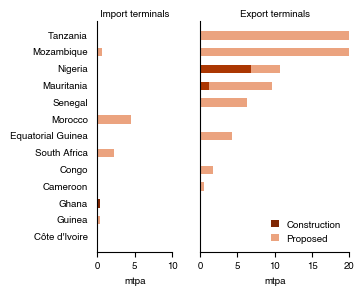

In [51]:
font_size = 7
set_width = 0.5
xmax1 = 10
xmax2 = 20

use_this_df = final_table.replace('', 0)
sorted_indices = final_table.replace('',numpy.nan).sum(axis=1).sort_values().index
use_this_df = use_this_df.reindex(sorted_indices)
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,3))

gs = fig.add_gridspec(1,2,width_ratios=(1,2),
                      wspace=0.25, hspace=0.)
ax1 = fig.add_subplot(gs[0,0])

ax1.barh(range(use_this_df.index.size), use_this_df['Construction Import'],
       color=tracker_construction, label='Construction', height=set_width)
ax1.barh(range(use_this_df.index.size), use_this_df['Proposed Import'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df['Construction Import'], height=set_width, alpha=0.5)

# ax_l,ax_h = ax.get_legend_handles_labels()
# ax1.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#ax1.spines['left'].set_visible(False)
ax1.tick_params(labelsize=font_size,
              left=False)
ax1.set_xlabel('mtpa', size=font_size)

ax1.yaxis.set_ticks(range(use_this_df.index.size))
ax1.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
ax1.set_xlim(0, xmax1)

ax1.text(s='Import terminals',
         x=0.5,y=1.01,
         transform=ax1.transAxes,
         ha='center',va='bottom',
         fontsize=font_size)

##################################################

ax2 = fig.add_subplot(gs[0,1])

ax2.barh(range(use_this_df.index.size), use_this_df['Construction Export'],
       color=tracker_construction, label='Construction', height=set_width)
ax2.barh(range(use_this_df.index.size), use_this_df['Proposed Export'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df['Construction Import'], height=set_width, alpha=0.5)

ax_l,ax_h = ax2.get_legend_handles_labels()
ax2.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax2.tick_params(labelsize=font_size,
              left=False)
ax2.set_xlabel('mtpa', size=font_size)

ax2.yaxis.set_ticks([])
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0, xmax2)

ax2.text(s='Export terminals',
         x=0.5,y=1.01,
         transform=ax2.transAxes,
         ha='center',va='bottom',
         fontsize=font_size)


In [52]:
sel_cmap = matplotlib.cm.get_cmap('Oranges')
export_con = sel_cmap(1.0)
export_prop = sel_cmap(0.75)

sel_cmap = matplotlib.cm.get_cmap('Purples')
import_con = sel_cmap(0.999)
import_prop = sel_cmap(0.666)

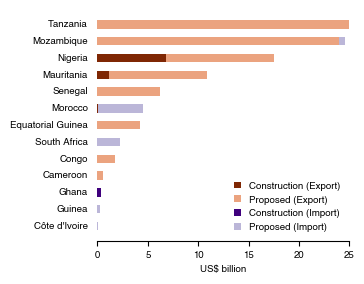

In [53]:
font_size = 7
set_width = 0.5
xmax = 25

use_this_df = final_table.replace('', 0)
sorted_indices = final_table.replace('',numpy.nan).sum(axis=1).sort_values().index
use_this_df = use_this_df.reindex(sorted_indices)
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,3))

ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Construction Export'],
       color=export_con, label='Construction (Export)', height=set_width)

ax.barh(range(use_this_df.index.size), use_this_df['Proposed Export'],
       color=export_prop, label='Proposed (Export)',
      left=use_this_df['Construction Export'], height=set_width, alpha=0.5)

ax.barh(range(use_this_df.index.size), use_this_df['Construction Import'],
       color=import_con,
        label='Construction (Import)', height=set_width,
        left=use_this_df[['Construction Export','Proposed Export']].sum(axis=1, min_count=0))

ax.barh(range(use_this_df.index.size), use_this_df['Proposed Import'],
       color=import_prop, alpha=0.5,
        label='Proposed (Import)',
      left=use_this_df[['Construction Export','Proposed Export','Construction Import']].sum(axis=1, min_count=0), 
         height=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('US$ billion', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
ax.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
ax.set_xlim(0, xmax)

mp.savefig('saved-figures/exports-and-imports-fig4.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/exports-and-imports-fig4.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/exports-and-imports-fig4.svg',
          bbox_inches='tight', 
          transparent=True)

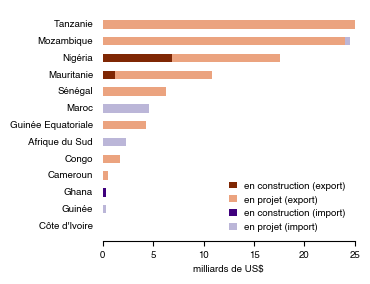

In [57]:
font_size = 7
set_width = 0.5
xmax = 25

use_this_df = final_table.replace('', 0)
sorted_indices = final_table.replace('',numpy.nan).sum(axis=1).sort_values().index
use_this_df = use_this_df.reindex(sorted_indices)
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,3))

ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Construction Export'],
       color=export_con, label='en construction (export)', height=set_width)

ax.barh(range(use_this_df.index.size), use_this_df['Proposed Export'],
       color=export_prop, label='en projet (export)',
      left=use_this_df['Construction Export'], height=set_width, alpha=0.5)

ax.barh(range(use_this_df.index.size), use_this_df['Construction Import'],
       color=import_con,
        label='en construction (import)', height=set_width,
        left=use_this_df[['Construction Export','Proposed Export']].sum(axis=1, min_count=0))

ax.barh(range(use_this_df.index.size), use_this_df['Proposed Import'],
       color=import_prop, alpha=0.5,
        label='en projet (import)',
      left=use_this_df[['Construction Export','Proposed Export','Construction Import']].sum(axis=1, min_count=0), 
         height=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('milliards de US$', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
fr_labels = ["Tanzanie",
"Mozambique",
"Nigéria",
"Mauritanie",
"Sénégal",
"Maroc",
"Guinée Equatoriale",
"Afrique du Sud",
"Congo",
"Cameroun",
"Ghana",
"Guinée",
"Côte d'Ivoire"][::-1]
ax.yaxis.set_ticklabels(fr_labels, size=font_size, va='center')
ax.set_xlim(0, xmax)

mp.savefig('saved-figures/exports-and-imports-fig4-Fr.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/exports-and-imports-fig4-Fr.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/exports-and-imports-fig4-Fr.svg',
          bbox_inches='tight', 
          transparent=True)

# table 14

In [58]:
status = ['Proposed','Construction','Proposed+Construction']
cost_by_country_import_df_subset = cost_by_country_import_df.loc[(cost_by_country_import_df.index.isin(region_df_touse.Country))]
cost_by_country_import_df_subset = cost_by_country_import_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(cost_by_country_import_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([cost_by_country_import_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table/1e9

,Proposed,Construction,Proposed+Construction
Country,,,
Morocco,4.50000,0.00000,4.50000
South Africa,2.26940,0.00000,2.26940
Mozambique,0.55000,0.00000,0.55000
Ghana,0.00000,0.35000,0.35000
Guinea,0.30000,0.00000,0.30000
Rest of Africa,0.05119,0.00000,0.05119
Total,7.67058,0.35000,8.02058


In [59]:
status = ['Proposed','Construction','Proposed+Construction']
cost_by_country_export_df_subset = cost_by_country_export_df.loc[(cost_by_country_export_df.index.isin(region_df_touse.Country))]
cost_by_country_export_df_subset = cost_by_country_export_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(cost_by_country_export_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([cost_by_country_export_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table/1e9

,Proposed,Construction,Proposed+Construction
Country,,,
Tanzania,30.00000,0.00000,30.00000
Mozambique,24.00000,0.00000,24.00000
Nigeria,10.69236,6.84211,17.53447
Mauritania,9.68595,1.15920,10.84515
Senegal,6.23595,0.00000,6.23595
Rest of Africa,6.44624,0.03813,6.48437
Total,87.06050,8.03944,95.09994
